In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [35]:
sns.set_context('talk')

# Read the data

In [36]:
test = pd.read_csv('csv/logit_insurance_test.csv')
train = pd.read_csv('csv/logit_insurance.csv')

In [37]:
train.shape

(8161, 26)

# Preprocessing

In [38]:
train.columns

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

In [39]:
index = pd.concat([train['INDEX'], test['INDEX']])
index.shape[0] - index.nunique()

0

Действительно, train и test не пересекаются

Теперь избавимся от капса в названиях столбцов

In [40]:
def rename_columns(df):
    df = df.rename(columns={'INDEX': 'id'})
    df = df.rename(columns=lambda x: x.lower())
    return df

In [41]:
train = rename_columns(train)
test = rename_columns(test)

In [42]:
train.columns

Index(['id', 'target_flag', 'target_amt', 'kidsdriv', 'age', 'homekids', 'yoj',
       'income', 'parent1', 'home_val', 'mstatus', 'sex', 'education', 'job',
       'travtime', 'car_use', 'bluebook', 'tif', 'car_type', 'red_car',
       'oldclaim', 'clm_freq', 'revoked', 'mvr_pts', 'car_age', 'urbanicity'],
      dtype='object')

Первая половина столбцов

In [43]:
train[['id', 'target_flag', 'target_amt', 'kidsdriv', 'age', 'homekids', 'yoj',\
       'income', 'parent1', 'home_val', 'mstatus', 'sex', 'education', 'job']].head(10)

,id,target_flag,target_amt,kidsdriv,age,homekids,yoj,income,parent1,home_val,mstatus,sex,education,job
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor
5,7,1,2946.0,0,34.0,1,12.0,"$125,301",Yes,$0,z_No,z_F,Bachelors,z_Blue Collar
6,8,0,0.0,0,54.0,0,NaN,"$18,755",No,NaN,Yes,z_F,<High School,z_Blue Collar
7,11,1,4021.0,1,37.0,2,NaN,"$107,961",No,"$333,680",Yes,M,Bachelors,z_Blue Collar
8,12,1,2501.0,0,34.0,0,10.0,"$62,978",No,$0,z_No,z_F,Bachelors,Clerical
9,13,0,0.0,0,50.0,0,7.0,"$106,952",No,$0,z_No,M,Bachelors,Professional


In [44]:
train[['travtime', 'car_use', 'bluebook', 'tif', 'car_type', 'red_car',
       'oldclaim', 'clm_freq', 'revoked', 'mvr_pts', 'car_age', 'urbanicity']].head(10)

,travtime,car_use,bluebook,tif,car_type,red_car,oldclaim,clm_freq,revoked,mvr_pts,car_age,urbanicity
0,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
5,46,Commercial,"$17,430",1,Sports Car,no,$0,0,No,0,7.0,Highly Urban/ Urban
6,33,Private,"$8,780",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
7,44,Commercial,"$16,970",1,Van,yes,"$2,374",1,Yes,10,7.0,Highly Urban/ Urban
8,34,Private,"$11,200",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
9,48,Commercial,"$18,510",7,Van,no,$0,0,No,1,17.0,z_Highly Rural/ Rural


target_flag -- предсказываем

target_amt -- сумма ремонта при аварии, выкидываем

id -- внутренний идентификатор, сделаем индексом

In [45]:
def first_clean(df):
    return df.drop('target_amt', axis=1).set_index('id')

In [46]:
train = first_clean(train)
test = first_clean(test)

Посмотрим, в каких столбцах есть пропуски и сколько их

In [47]:
columns_with_nans = train.shape[0] - train.count(axis=0)
columns_with_nans = columns_with_nans[columns_with_nans > 0]
columns_with_nans

age           6
yoj         454
income      445
home_val    464
job         526
car_age     510
dtype: int64

In [48]:
columns_with_nans_test = test.shape[0] - test.count(axis=0)
columns_with_nans_test = columns_with_nans_test[columns_with_nans_test > 0]
columns_with_nans_test

target_flag    2141
age               1
yoj              94
income          125
home_val        111
job             139
car_age         129
dtype: int64

## Пройдёмся по каждому признаку, определим его тип и что будем с ним делать

### kidsriv

In [49]:
train['kidsdriv'].value_counts()

0    7180
1     636
2     279
3      62
4       4
Name: kidsdriv, dtype: int64

In [50]:
train['kidsdriv'].dtype

dtype('int64')

Как я понимаю, kidsriv -- монотонно возврастающая функция от числа перевозимых детей (0, 1, 2, 3, много)

### age

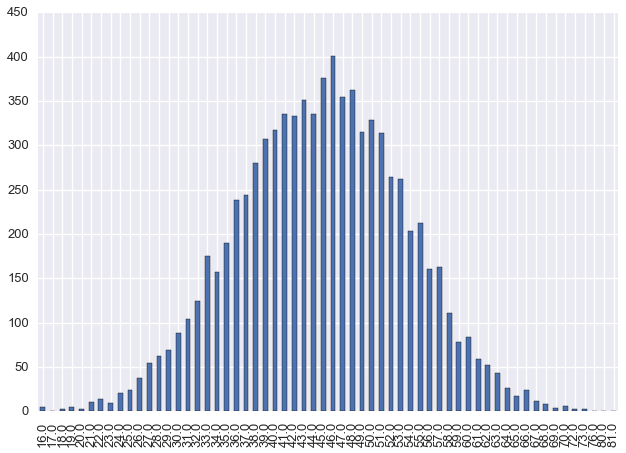

In [51]:
train['age'].value_counts().sort_index().plot(kind='bar')

In [52]:
train['age'].dtype

dtype('float64')

Со столбцом age всё ясно. Пропуски я бы заполнил модой (most popular). 

### homekids

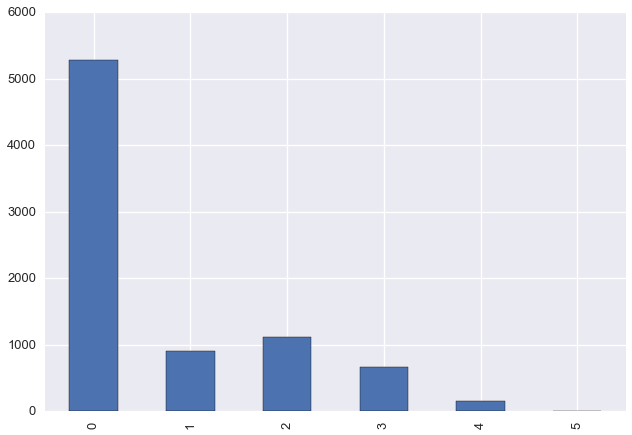

In [53]:
train['homekids'].value_counts().sort_index().plot(kind='bar')

In [54]:
train['homekids'].dtype

dtype('int64')

homekids -- число детей "дома". Скорее всего, число несовершеннолетних детей или детей на иждивении. Ну, или конкретно число детей в доме

### yoj

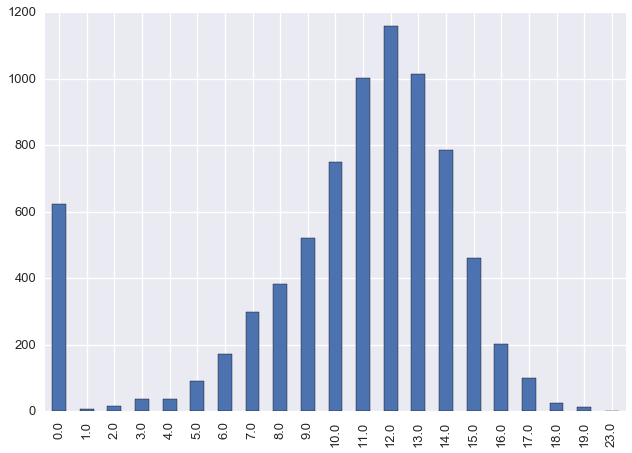

In [55]:
train['yoj'].value_counts().sort_index().plot(kind='bar')

In [56]:
train['yoj'].dtype

dtype('float64')

In [57]:
columns_with_nans['yoj']

454

Я пока не понимаю, что такое этот yoj. Пропуски будем заменять модой или нулём. Заметим, что ноль может быть синонимом пропуска

### income

In [58]:
train['income'].dtype

dtype('O')

In [59]:
train.shape[0] - train['income'].str.startswith('$').shape[0]

0

In [60]:
test.shape[0] - test['income'].str.startswith('$').shape[0]

0

Каждый элемент начинается со знака доллара. Обрежем его и уберём запятые, которые разделяют тысячи

In [61]:
def dollar_comma_inputer(series):
    return series.map(lambda x: np.float64(''.join(str(x).lstrip('$').split(','))))

In [62]:
train['income'] = dollar_comma_inputer(train['income'])
test['income'] = dollar_comma_inputer(test['income'])

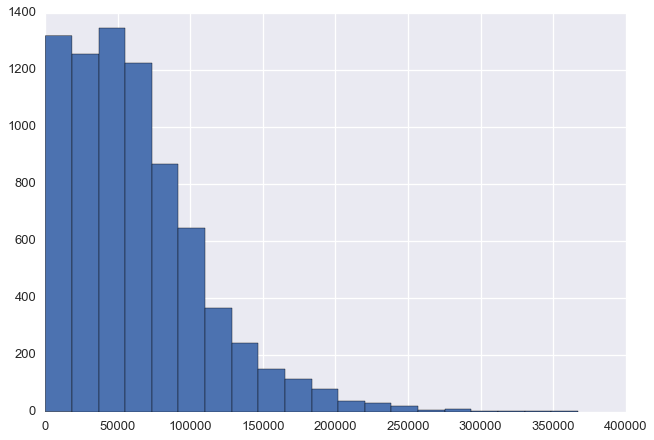

In [63]:
train['income'].hist(bins=20)

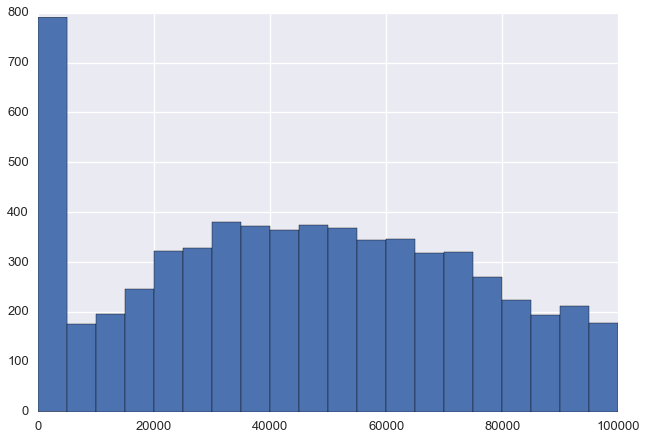

In [64]:
train[train['income'] < 100000]['income'].hist(bins=20)

In [65]:
train[train['income'] == 0].shape[0]

615

In [66]:
train[train['income'].isnull()].shape[0]

445

Нули опять похожи на пропуски. Пропуски можно заменить на медианы или на нули. Заметим, что пропусков и нулей много, где-то 1/8 train'а

### parent1

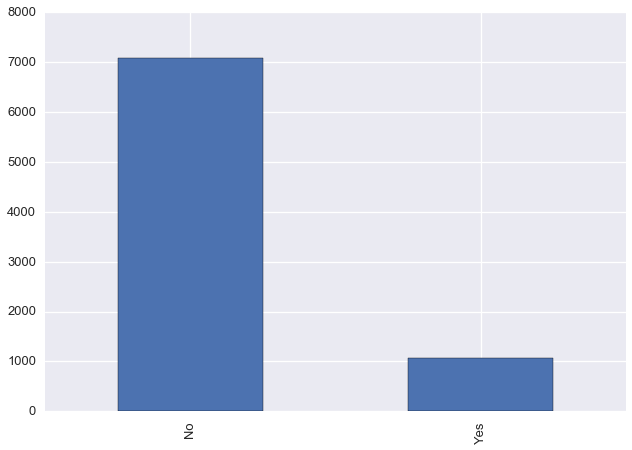

In [67]:
train['parent1'].value_counts().sort_index().plot(kind='bar')

Первый категориальный признак. С ним всё просто, так как он бинарный и пропусков нет

In [68]:
categorical = ['parent1']

### home_val

In [69]:
train['home_val'] = dollar_comma_inputer(train['home_val'])
test['home_val'] = dollar_comma_inputer(test['home_val'])

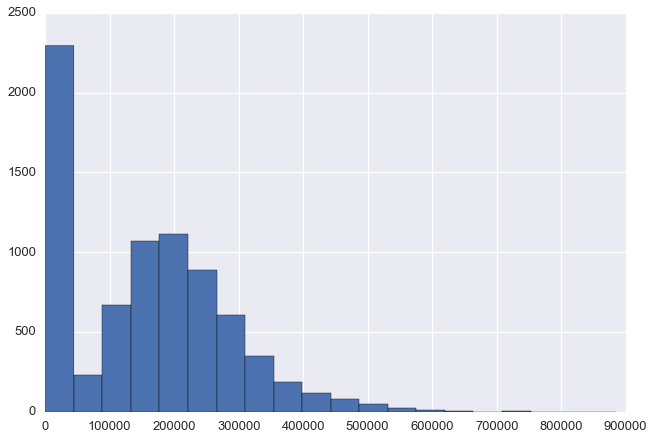

In [70]:
train['home_val'].hist(bins=20)

Что-то опять намекает на соответствие пропусков и нулей

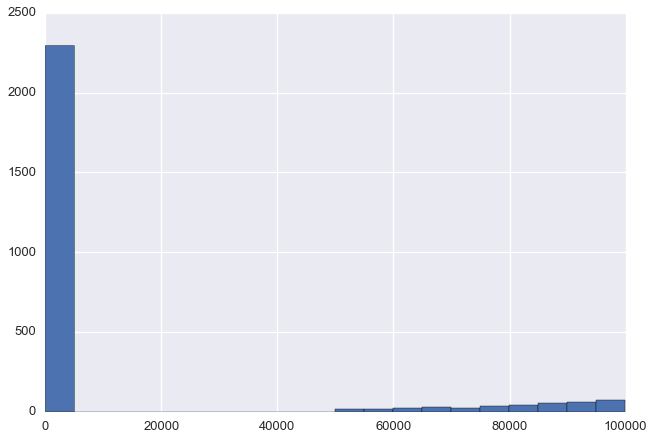

In [71]:
train[train['home_val'] < 100000]['home_val'].hist(bins=20)

In [72]:
train[train['home_val'] == 0].shape[0]

2294

In [73]:
train[train['home_val'].isnull()].shape[0]

464

Треть train'а состоит из нулей или пропусков.

Пропуски будем заменять нулями. 

## mstatus

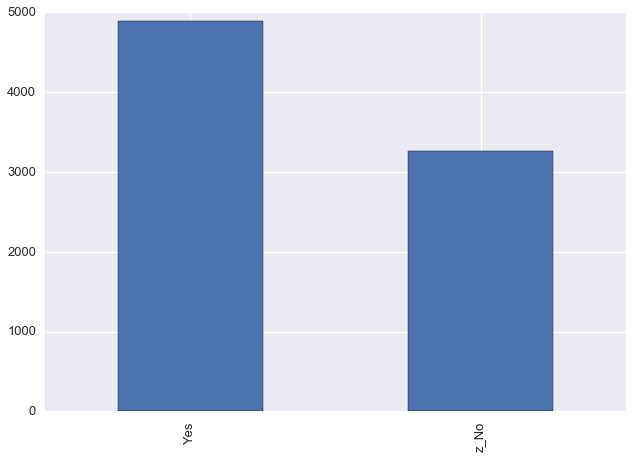

In [74]:
train['mstatus'].value_counts().sort_index().plot(kind='bar')

Тут тоже всё просто. 

In [75]:
categorical.append('mstatus')

## sex

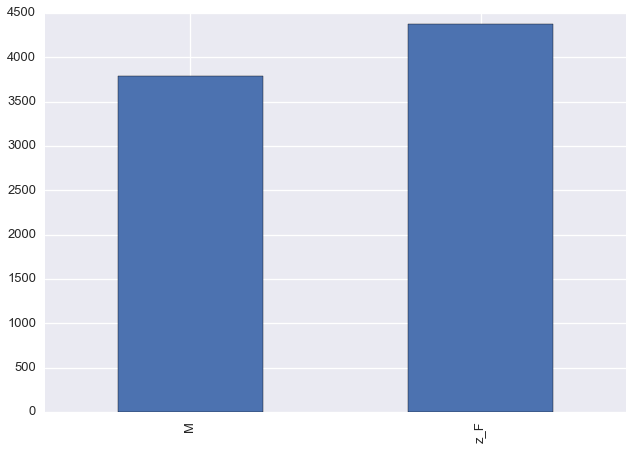

In [76]:
train['sex'].value_counts().sort_index().plot(kind='bar')

In [77]:
categorical.append('sex')

## education

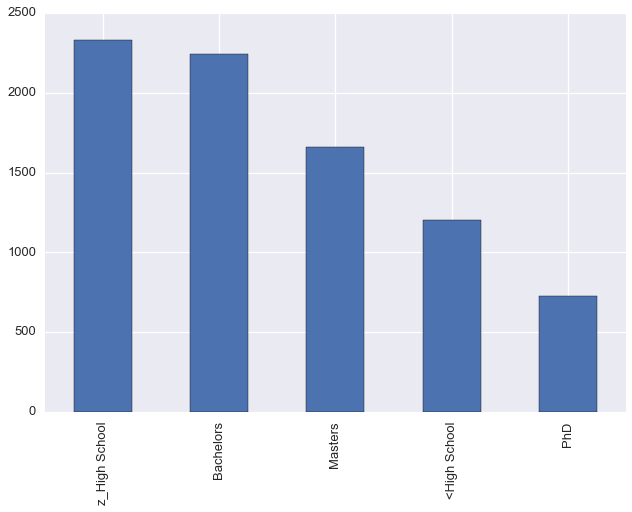

In [78]:
train['education'].value_counts().plot(kind='bar')

In [79]:
categorical.append('education')

## job

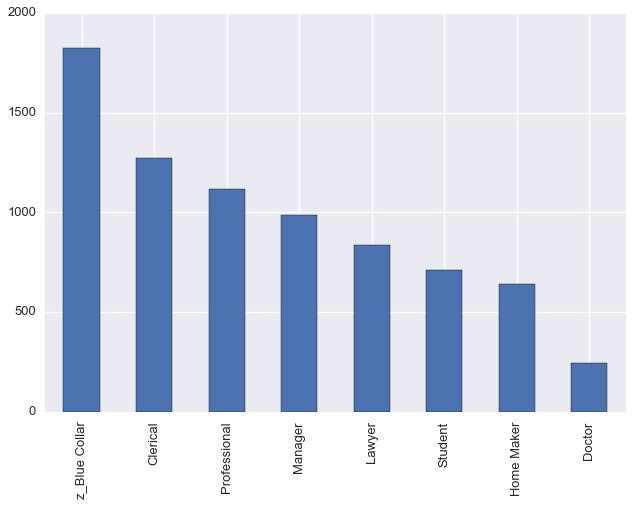

In [80]:
train['job'].value_counts().plot(kind='bar')

In [81]:
columns_with_nans['job']

526

In [82]:
categorical.append('job')

Пропускои заменим модой, то есть рабочими. Также пропуски можно превратить в отдельную профессию

In [83]:
categorical

['parent1', 'mstatus', 'sex', 'education', 'job']

## Second half of features

In [84]:
train[['travtime', 'car_use', 'bluebook', 'tif', 'car_type', 'red_car',
       'oldclaim', 'clm_freq', 'revoked', 'mvr_pts', 'car_age', 'urbanicity']].head(10)

,travtime,car_use,bluebook,tif,car_type,red_car,oldclaim,clm_freq,revoked,mvr_pts,car_age,urbanicity
id,,,,,,,,,,,,
1,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
7,46,Commercial,"$17,430",1,Sports Car,no,$0,0,No,0,7.0,Highly Urban/ Urban
8,33,Private,"$8,780",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
11,44,Commercial,"$16,970",1,Van,yes,"$2,374",1,Yes,10,7.0,Highly Urban/ Urban
12,34,Private,"$11,200",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban


## travtime

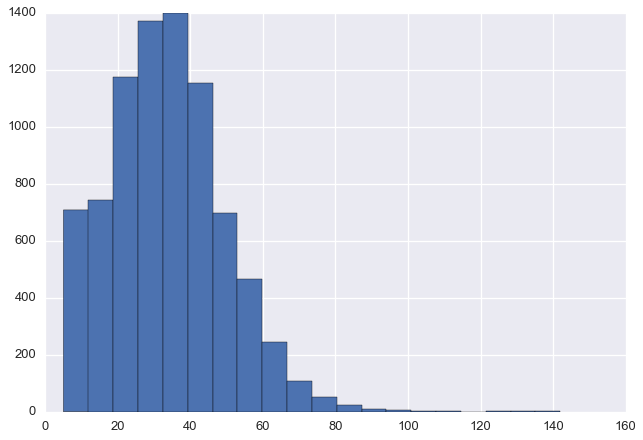

In [85]:
train['travtime'].hist(bins=20)

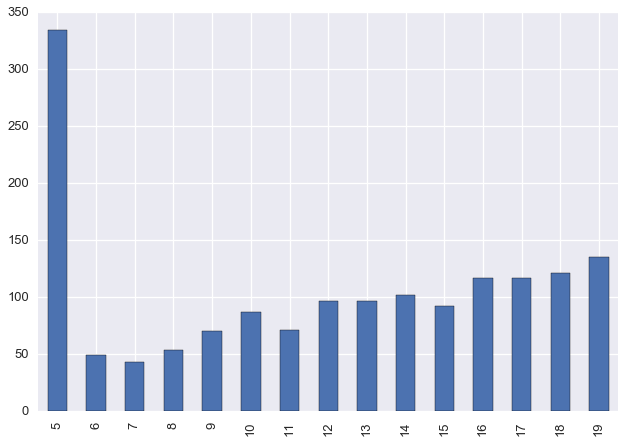

In [86]:
train[train['travtime'] < 20]['travtime'].value_counts().sort_index().plot(kind='bar')

In [87]:
train['travtime'].dtype

dtype('int64')

## car_use

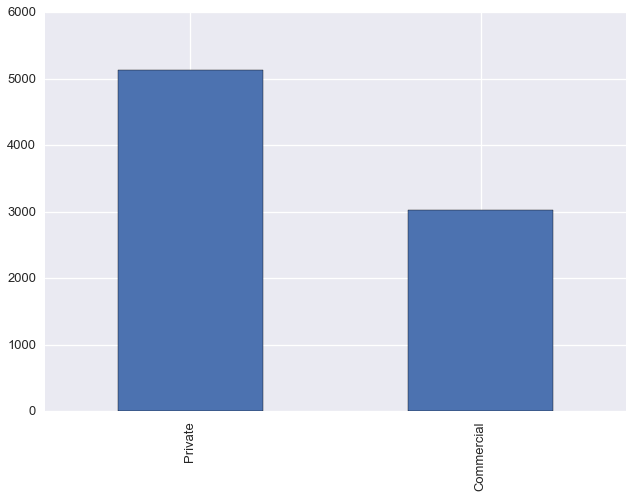

In [88]:
train['car_use'].value_counts().plot(kind='bar')

In [89]:
categorical.append('car_use')

## bluebook

In [90]:
train['bluebook'] = dollar_comma_inputer(train['bluebook'])
test['bluebook'] = dollar_comma_inputer(test['bluebook'])

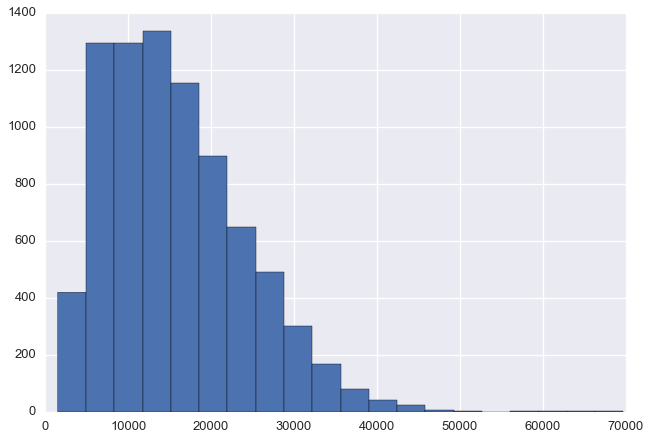

In [91]:
train['bluebook'].hist(bins=20)

## tif

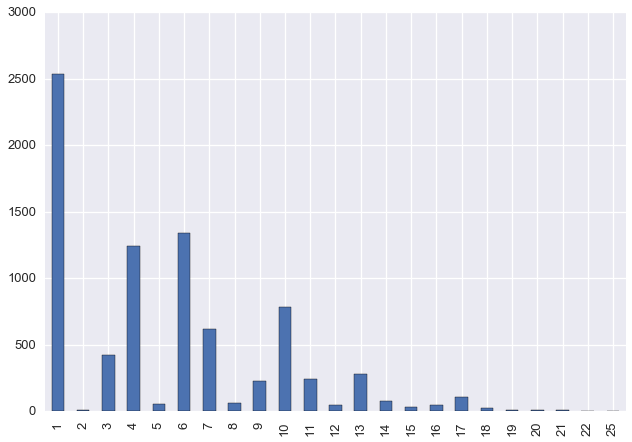

In [92]:
train['tif'].value_counts().sort_index().plot(kind='bar')

## car_type

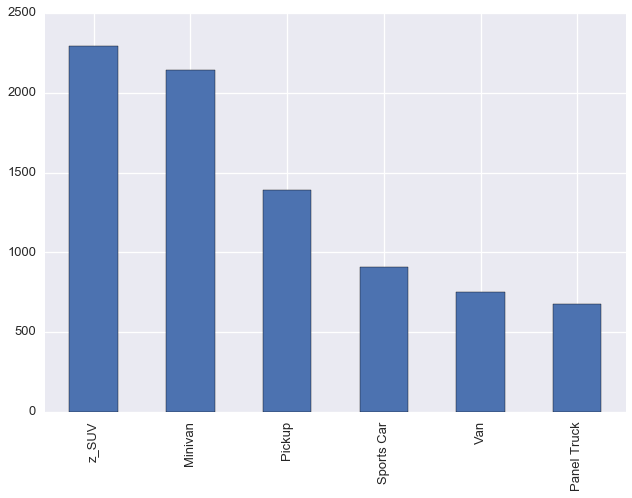

In [93]:
train['car_type'].value_counts().plot(kind='bar')

In [94]:
categorical.append('car_type')

## red_car

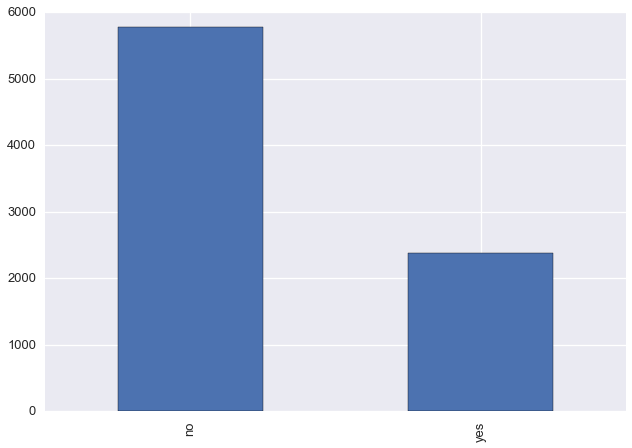

In [95]:
train['red_car'].value_counts().plot(kind='bar')

In [96]:
categorical.append('red_car')

## oldclaim

In [97]:
train['oldclaim'] = dollar_comma_inputer(train['oldclaim'])
test['oldclaim'] = dollar_comma_inputer(test['oldclaim'])

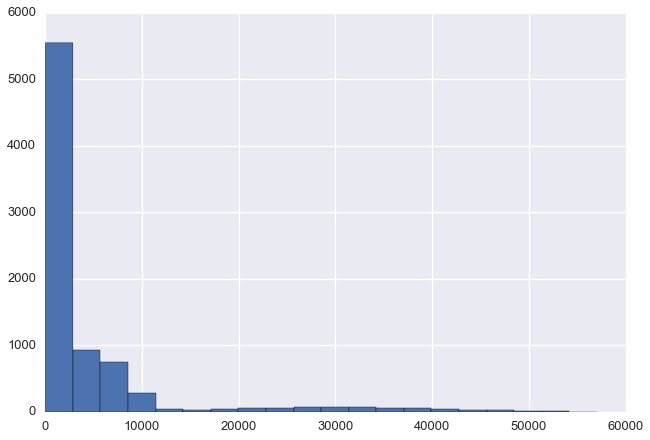

In [98]:
train['oldclaim'].hist(bins=20)

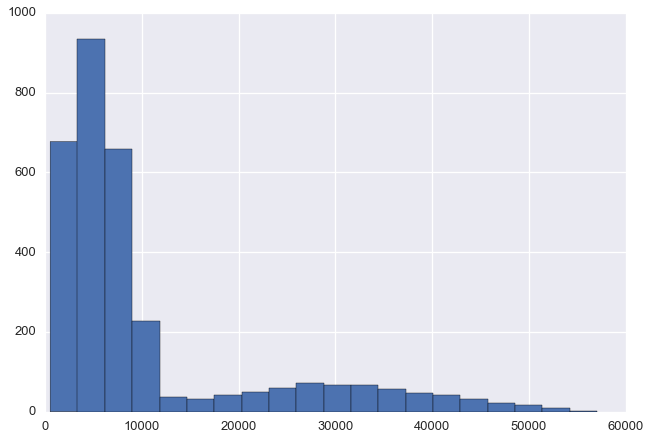

In [99]:
train[train['oldclaim'] > 0]['oldclaim'].hist(bins=20)

## clm_freq

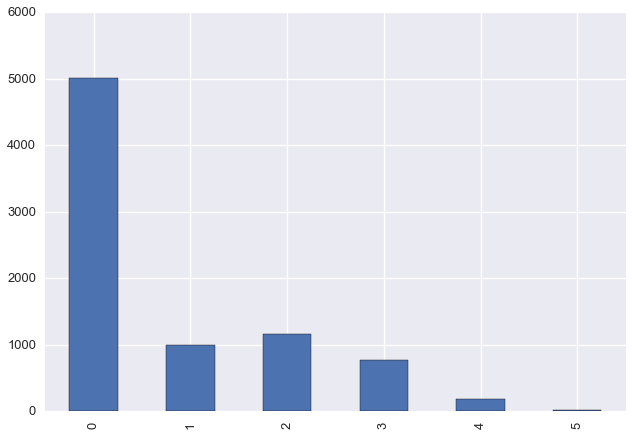

In [100]:
train['clm_freq'].value_counts().sort_index().plot(kind='bar')

## revoked

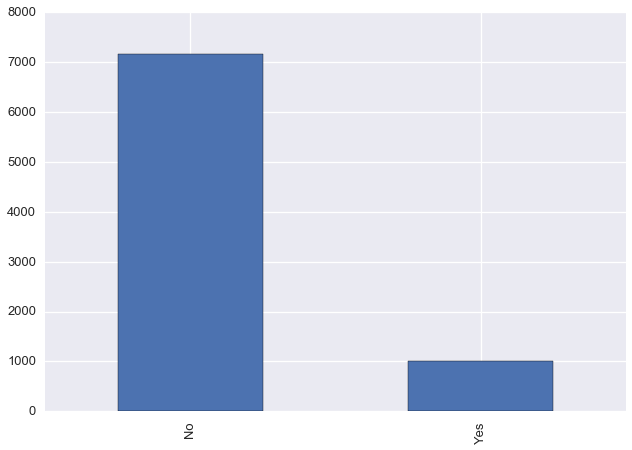

In [101]:
train['revoked'].value_counts().plot(kind='bar')

In [102]:
categorical.append('revoked')

## mvr_pts

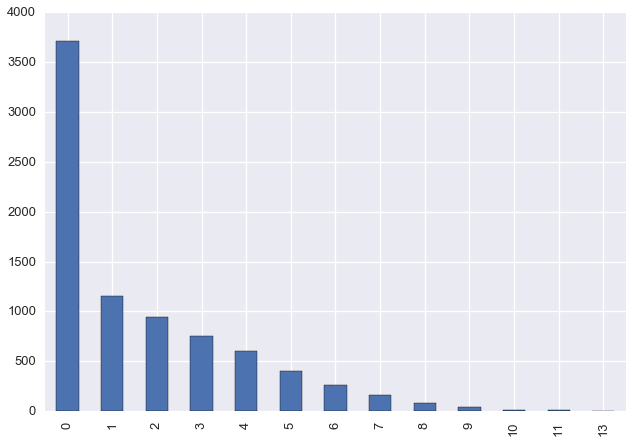

In [103]:
train['mvr_pts'].value_counts().sort_index().plot(kind='bar')

## car_age

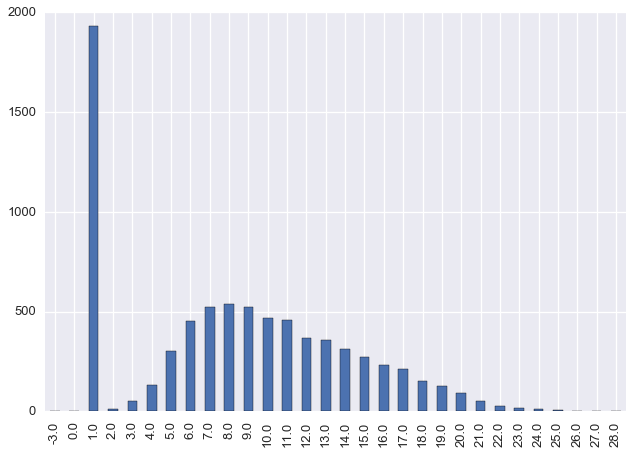

In [104]:
train['car_age'].value_counts().sort_index().plot(kind='bar')

In [105]:
columns_with_nans['car_age']

510

In [106]:
train[train['car_age'] < 1].shape[0]

4

Пропуски заменим модой (единица)

## urbanicity

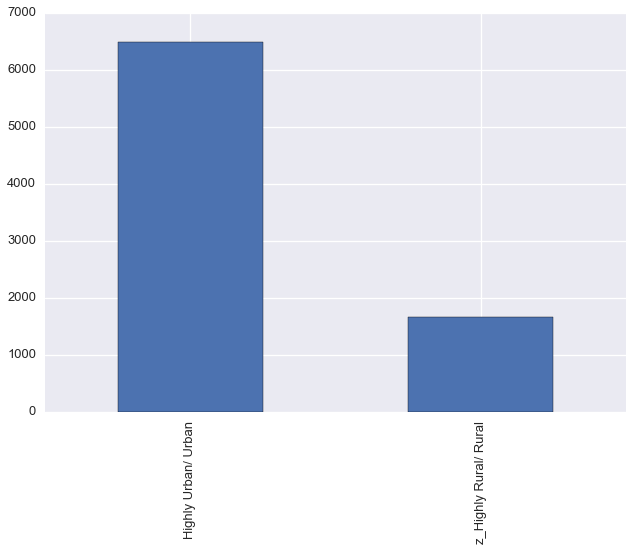

In [107]:
train['urbanicity'].value_counts().plot(kind='bar')

In [108]:
categorical.append('urbanicity')

# Dealing with missing data

In [109]:
columns_with_nans

age           6
yoj         454
income      445
home_val    464
job         526
car_age     510
dtype: int64

yoj, income, home_val -- аномалии в нуле

car_age -- аномалия в единице

age -- нет аномалий

пропуски заменяем на -1

создаём по бинарному признаку на пропуск и аномалию

job -- создаём класс other для пропусков

In [110]:
nan_numeric_cols = ['yoj', 'income', 'home_val', 'age', 'car_age']
anomaly = {'car_age': 1, 'income': 0, 'home_val': 0, 'yoj': 0}

def df_fillna(df):
    for col in nan_numeric_cols:
        df[col + '_nan'] = 0
        df.loc[df[col].isnull(), col + '_nan'] = 1
        df[col].fillna(-1, inplace=True)    
    
    for col, ano in anomaly.items():
        df[col + '_ano'] = 0
        df.loc[df[col] == ano, col + '_ano'] = 1
    
    df['job'].fillna('Other', inplace=True)

In [111]:
df_fillna(train)
df_fillna(test)

# Target label separation 

In [113]:
y_train = train['target_flag']
train = train.drop('target_flag', axis=1)
test = test.drop('target_flag', axis=1)

# Order columns

Сначала численные, потом категориальные

In [115]:
nan_features = [col + '_nan' for col in nan_numeric_cols]
ano_features = [col + '_ano' for col in anomaly]

In [118]:
numerical = list(set(test.columns.tolist()) - set(categorical) - set(nan_features) - set(ano_features))
numerical

['travtime',
 'homekids',
 'tif',
 'income',
 'bluebook',
 'clm_freq',
 'oldclaim',
 'car_age',
 'home_val',
 'age',
 'kidsdriv',
 'yoj',
 'mvr_pts']

In [119]:
len(numerical)

13

In [120]:
columns = numerical + categorical + nan_features + ano_features
columns

['travtime',
 'homekids',
 'tif',
 'income',
 'bluebook',
 'clm_freq',
 'oldclaim',
 'car_age',
 'home_val',
 'age',
 'kidsdriv',
 'yoj',
 'mvr_pts',
 'parent1',
 'mstatus',
 'sex',
 'education',
 'job',
 'car_use',
 'car_type',
 'red_car',
 'revoked',
 'urbanicity',
 'yoj_nan',
 'income_nan',
 'home_val_nan',
 'age_nan',
 'car_age_nan',
 'car_age_ano',
 'yoj_ano',
 'home_val_ano',
 'income_ano']

In [121]:
train = train[columns]
test = test[columns]

In [122]:
train.head()

,travtime,homekids,tif,income,bluebook,clm_freq,oldclaim,car_age,home_val,age,...,urbanicity,yoj_nan,income_nan,home_val_nan,age_nan,car_age_nan,car_age_ano,yoj_ano,home_val_ano,income_ano
id,,,,,,,,,,,,,,,,,,,,,
1,14,0,11,67349.0,14230.0,2,4461.0,18.0,0.0,60.0,...,Highly Urban/ Urban,0,0,0,0,0,0,0,1,0
2,22,0,1,91449.0,14940.0,0,0.0,1.0,257252.0,43.0,...,Highly Urban/ Urban,0,0,0,0,0,1,0,0,0
4,5,1,4,16039.0,4010.0,2,38690.0,10.0,124191.0,35.0,...,Highly Urban/ Urban,0,0,0,0,0,0,0,0,0
5,32,0,7,-1.0,15440.0,0,0.0,6.0,306251.0,51.0,...,Highly Urban/ Urban,0,1,0,0,0,0,0,0,0
6,36,0,1,114986.0,18000.0,2,19217.0,17.0,243925.0,50.0,...,Highly Urban/ Urban,1,0,0,0,0,0,0,0,0


# Encode categorical features

In [123]:
categorical

['parent1',
 'mstatus',
 'sex',
 'education',
 'job',
 'car_use',
 'car_type',
 'red_car',
 'revoked',
 'urbanicity']

In [124]:
categorical_binary = ['parent1', 'mstatus', 'sex', 'car_use', 'red_car', 'revoked', 'urbanicity']

In [125]:
categorical_multi = list(set(categorical) - set(categorical_binary))
categorical_multi

['job', 'education', 'car_type']

In [126]:
train = pd.get_dummies(train, columns=categorical_binary, drop_first=True)
test = pd.get_dummies(test, columns=categorical_binary, drop_first=True)

In [127]:
train = pd.get_dummies(train, columns=categorical_multi)
test = pd.get_dummies(test, columns=categorical_multi)

In [128]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [129]:
train.shape

(8161, 49)

# Save to file 

In [130]:
y_train.to_csv('preprocessed_csv/y_train_more.csv')

In [131]:
train.to_csv('preprocessed_csv/train_more.csv')

In [132]:
test.to_csv('preprocessed_csv/test_more.csv')